
# Low–cost holography for structured light

ABSTRACT

In this work, we present a scheme to produce low–cost amplitude holograms for the generation of structured light fields. We demonstrate the feasibility of this technique by creating a variety of paraxial modes, such as the well–known Laguerre– and Hermite–Gaussian beams.

## Required libraries

In [22]:
using Plots
using Beams
using Images
using FFTW
using FileIO
using Colors
using Statistics
using ImageFiltering

## Beam Definition

We are going to define a field $U(x,y,z)$ at the plane $z=0$.  Then we will then assign a wavevector $\vec{k} = k_x\hat{x} + k_y\hat{y} + k_z\hat{z}$ to the defined mode.

In [16]:
# SPATIAL SCALE
Ux=(15.36E-3)/2  # divide by 2! <-- consider the whole screen 
Uy=(8.64E-3)/2   # divide by 2! <-- consider the whole screen 
# Ux=0.0254/2   # divide by 2! <-- consider the whole screen 
# Uy=0.0254/2   # divide by 2! <-- consider the whole screen 
Hsize=div(1920,1); #300 1920 1440
Vsize=div(1080,1); #300 1080 900
 
# Generates ranges for xs and ys
ys = Ux*(2/Hsize)*collect(range(-Hsize/2,length=Hsize,stop=Hsize/2-1))
xs = Uy*(2/Vsize)*collect(range(-Vsize/2,length=Vsize,stop=Vsize/2-1))

# Coordinates
mx, ny = length(xs), length(ys)
Ys = reshape(xs, mx, 1)
Xs = reshape(ys, 1, ny);

## Binary method: Transmitance function 

Transmittance function 

In [17]:
lamb = 633E-9
w0 = 1.5E-3

# \vec{k} = (kx,ky,kz)
gamm = pi/500     # angle respect z
thxy = 0.0        # angle in the xy plane, with respect x axis
k = 2pi/lamb
kxy = k*sin(gamm)
kx = kxy*cos(thxy)
ky = kxy*sin(thxy);

### Theoretical Results

#### Hermite-Gauss Beam

$$
I(x,y) = \frac{2}{\pi w_0^2} \frac{1}{2^{n+1}n!} \left(\frac{\sqrt{2}x}{w_0}\right)^{2n} \left(\frac{\sqrt{2}y}{w_0}\right)^{2n} e^{-\frac{x^2+y^2}{w_0^2}}
$$

where:

- $I(x,y)$ is the intensity of the beam at position $(x,y)$ in the transverse plane.
- $w_0$ is the beam waist, which is the smallest diameter of the beam.

The formula for a Hermite-Gauss beam describes a beam that has a Gaussian shape in the transverse plane, with $n$ intensity peaks in the $x$ and $y$ directions. The size of the beam waist $w_0$ determines the overall size of the beam, with smaller beam waists corresponding to more tightly focused beams.

In [24]:
# HERMITE GAUSS
m = 2
n = 1
phi0 = 0.0
@time V = HermiteGaussBeam.(Xs, Ys, 0.0, w0, phi0, lamb, m, n);

  0.510761 seconds (40 allocations: 31.642 MiB, 6.52% gc time)


In [36]:
using Plots
using FileIO
using MAT
using Images
using ImageMagick

modes = [(1, 0), (2, 0), (1, 1), (2, 1)]
phi0 = 0.0

# Crop the image to a 1:1 aspect ratio
function crop_center(Amp, width, height)
    x1 = div(size(Amp, 1) - width, 2) + 1
    x2 = x1 + width - 1
    y1 = div(size(Amp, 2) - height, 2) + 1
    y2 = y1 + height - 1
    return Amp[x1:x2, y1:y2]
end

for (m, n) in modes
    V = HermiteGaussBeam.(Xs, Ys, 0.0, w0, phi0, lamb, m, n);
    Amp = abs.(V).^2
    Amp = Amp./maximum(Amp)

    Plots.heatmap(Amp, aspect_ratio=1, color=:grays, axis=:off, grid=:off, ticks=:false, colorbar=:false, clims=(0,1), size=(300,300))

    # Set the desired cropped width and height
    crop_width = 1024
    crop_height = 1024

    # Crop the amplitude matrix
    Amp_cropped = crop_center(Amp, crop_width, crop_height)

    # Convert the cropped amplitude matrix to an image
    Amp_image = Gray.(Amp_cropped)

    filename = "HG$(m)$(n)_num.bmp"
    dirnameST = "D:\\Drive\\ITESM 2017-2022\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\Code Backup\\output_bmp\\$filename"
    save(dirnameST, Amp_image)
    println("Save completed for mode (m=$(m), n=$(n))")

    # Save the cropped amplitude matrix to a .mat file
    filename = "HG$(m)$(n)_num.mat"
    dirnameST = "D:\\Drive\\ITESM 2017-2022\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\Code Backup\\output_mat\\$filename"
    matfile = matopen(dirnameST, "w")
    write(matfile, "numericData", Amp_cropped)
    close(matfile)
    println("Save completed for mode (m=$(m), n=$(n))")

end

Save completed for mode (m=1, n=0)
Save completed for mode (m=1, n=0)


Save completed for mode (m=2, n=0)
Save completed for mode (m=2, n=0)


Save completed for mode (m=1, n=1)
Save completed for mode (m=1, n=1)


Save completed for mode (m=2, n=1)
Save completed for mode (m=2, n=1)


#### Laguerre-Gauss Beam

$$
u_{\ell,p}(r,\theta,z) = \frac{C_{\ell,p}}{w(z)}\left(\frac{\sqrt{2}r}{w(z)}\right)^{|\ell|}e^{-r^2/w^2(z)}L_p^{|\ell|}\left(\frac{2r^2}{w^2(z)}\right)e^{-i\ell\theta}e^{ikz-ikr^2/2z}
$$

where:

- $u_{\ell,p}(r,\theta,z)$ is the complex amplitude of the beam at position $(r,\theta,z)$.
- $C_{\ell,p}$ is a normalization constant.
- $w(z)$ is the beam width at position $z$.
- $L_p^{|\ell|}(x)$ is an associated Laguerre polynomial.
- $k$ is the wavenumber of the beam.
- $\ell$ is an integer that represents the azimuthal mode number.
- $p$ is an integer that represents the radial mode number.

The Laguerre-Gauss beam has a characteristic intensity profile that consists of concentric rings with a dark spot at the center. The phase of the beam varies smoothly around the rings, creating a spiral phase structure.

In [24]:
# LAGUERRE GAUSS
l = 1
p = 0
V = LaguerreGaussBeam.(Xs, Ys, 0.0, w0, 0.0, lamb, l, p);

#### Amplitude calculation and heatmap generation for theoretical results

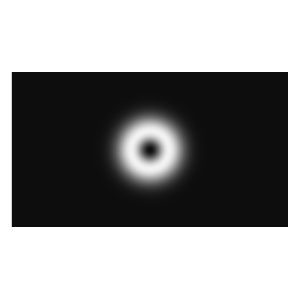

In [25]:
# Amplitude
Amp = abs.(V).^2
Amp = Amp./maximum(Amp)

Plots.heatmap(Amp, aspect_ratio=1, color=:grays, axis=:off, grid=:off, ticks=:false, colorbar=:false, clims=(0,1), size=(300,300))

"Save" function for generated results (Change path according to your device)

In [39]:
savestuff = true

if savestuff
dirnameST = "D:\\Drive\\ITESM 2017-2022\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\Theoretical\\LG21.bmp";
    save(dirnameST,colorview(Gray, Amp))
    println("Save completed")
end

Save completed


In [37]:
using Plots
using FileIO
using MAT
using Images
using ImageMagick

modes = [(1, 0), (2, 0), (1, 1), (2, 1)]
   
# Crop the image to a 1:1 aspect ratio
function crop_center(Amp, width, height)
    x1 = div(size(Amp, 1) - width, 2) + 1
    x2 = x1 + width - 1
    y1 = div(size(Amp, 2) - height, 2) + 1
    y2 = y1 + height - 1
    return Amp[x1:x2, y1:y2]
end

for (l, p) in modes
    V = LaguerreGaussBeam.(Xs, Ys, 0.0, w0, 0.0, lamb, l, p)
    Amp = abs.(V).^2
    Amp = Amp./maximum(Amp)

    Plots.heatmap(Amp, aspect_ratio=1, color=:grays, axis=:off, grid=:off, ticks=:false, colorbar=:false, clims=(0,1), size=(300,300))

    # Set the desired cropped width and height
    crop_width = 1024
    crop_height = 1024

    # Crop the amplitude matrix
    Amp_cropped = crop_center(Amp, crop_width, crop_height)

    # Convert the cropped amplitude matrix to an image
    Amp_image = Gray.(Amp_cropped)

    filename = "LG$(l)$(p)_num.bmp"
    dirnameST = "D:\\Drive\\ITESM 2017-2022\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\Code Backup\\output_bmp\\$filename"
    save(dirnameST, Amp_image)
    println("Save completed for mode (l=$(l), p=$(p))")

    # Save the cropped amplitude matrix to a .mat file
    filename = "LG$(l)$(p)_num.mat"
    dirnameST = "D:\\Drive\\ITESM 2017-2022\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\Code Backup\\output_mat\\$filename"
    matfile = matopen(dirnameST, "w")
    write(matfile, "numericData", Amp_cropped)
    close(matfile)
    println("Save completed for mode (l=$(l), p=$(p))")

end

Save completed for mode (l=1, p=0)
Save completed for mode (l=1, p=0)


Save completed for mode (l=2, p=0)
Save completed for mode (l=2, p=0)


Save completed for mode (l=1, p=1)
Save completed for mode (l=1, p=1)


Save completed for mode (l=2, p=1)
Save completed for mode (l=2, p=1)


### Hologram Creation

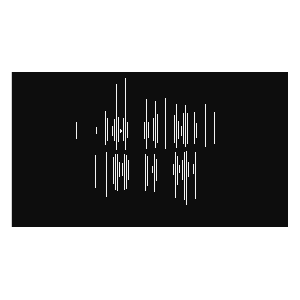

In [7]:
# Amplitude
Amp = abs.(V)
Amp = Amp./maximum(Amp)

# Phase
Phi = angle.(V)

pp = asin.(Amp)
qq = Phi .+ (kx*Xs .+ ky*Ys)

TT = 0.5 .+ 0.5*sign.(cos.(pp) .+ cos.(qq))
TTb = 1.0 .- TT

heatmap(TTb, aspect_ratio=1, color=:grays, axis=:off, grid=:off, ticks=:false, colorbar=:false, clims=(0,1), size=(300,300))

"Save" function for generated results (Change path according to your device)

In [ ]:
savestuff = true

if savestuff
dirnameST = "D:\\Drive\\ITESM\\ONCEAVO SEMESTRE\\Proyecto de Ingeniería IV\\Hologramas\\150123\\Hologramas\\HG21.bmp";
    save(dirnameST,colorview(Gray, TTb))
    println("Save completed")
end